# Serverless Forecasting

1. Generate traces, start platform, run functions according to traces, continously fit models (10 seconds in advance) to set the number of warmed instances/warming period  
(Do the same thing for one with a fixed warming period and no prewarmed instances)

In [2]:
from main import main
trace, scheduler, instances = await main(100)
_, scheduler_no, instances_no = await main(100, False)

Starting dataset processing...
Extracted function...
Extracted invocation counts...
Done processing (took 1.16 seconds)
                          ds  y
0 2025-03-13 11:54:57.914360  1
1 2025-03-13 11:54:58.914360  2
2 2025-03-13 11:54:59.914360  1
3 2025-03-13 11:55:00.914360  1
4 2025-03-13 11:55:01.914360  1


65it [01:13,  1.14s/it]


Starting dataset processing...
Extracted function...
Extracted invocation counts...
Done processing (took 1.16 seconds)
                          ds  y
0 2025-03-13 11:56:16.985292  1
1 2025-03-13 11:56:17.985292  2
2 2025-03-13 11:56:18.985292  1
3 2025-03-13 11:56:19.985292  1
4 2025-03-13 11:56:20.985292  1


65it [01:13,  1.14s/it]


2. Parse logs

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

pruned_logs = filter(lambda x: x['log_type'] == "prune_info", scheduler.platform.logs)
pruned_logs_no = filter(lambda x: x['log_type'] == "prune_info", scheduler_no.platform.logs)

remaining_instances = pd.DataFrame(pruned_logs)
remaining_instances['ds'] = pd.to_datetime(remaining_instances["entry_time"], unit='s') - pd.Timedelta('07:00:00')
remaining_instances = remaining_instances[remaining_instances['ds'] <= max(trace['ds'])]
remaining_instances['num'] = remaining_instances['remaining_count'].map(lambda x: x['sleep'])

remaining_instances_no = pd.DataFrame(pruned_logs_no)
remaining_instances_no['ds'] = pd.to_datetime(remaining_instances_no["entry_time"], unit='s') - pd.Timedelta('07:00:00')
diff = min(remaining_instances_no['ds']) - min(remaining_instances['ds'])
remaining_instances_no['ds'] = remaining_instances_no['ds'] - diff
remaining_instances_no = remaining_instances_no[remaining_instances_no['ds'] <= max(trace['ds'])]
remaining_instances_no['num'] = remaining_instances_no['remaining_count'].map(lambda x: x['sleep'])

In [4]:
invoke_logs = filter(lambda x: x['log_type'] == "invocation_trace", scheduler.platform.logs)
invoke_logs_no = filter(lambda x: x['log_type'] == "invocation_trace", scheduler_no.platform.logs)

invoked = pd.DataFrame(invoke_logs)
invoked['ds'] = pd.to_datetime(invoked["entry_time"], unit='s') - pd.Timedelta('07:00:00')

invoked_no = pd.DataFrame(invoke_logs_no)
invoked_no['ds'] = pd.to_datetime(invoked_no["entry_time"], unit='s') - pd.Timedelta('07:00:00')
diff = min(invoked_no['ds']) - min(invoked['ds'])
invoked_no['ds'] = invoked_no['ds'] - diff

3. Evaluate accuracy of predictions

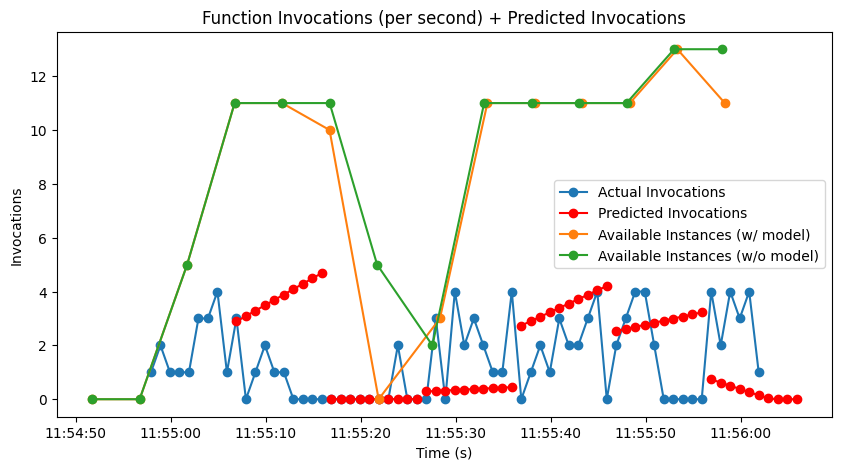

In [5]:
plt.figure(figsize=(10, 5))
plt.title("Function Invocations (per second) + Predicted Invocations")
plt.xlabel("Time (s)")
plt.ylabel("Invocations")
plt.plot(trace['ds'], trace['y'], '-o', label="Actual Invocations")

for pred in scheduler.predictions:
    plt.plot(pred['ds'], list(map(lambda x: 0 if x < 0 else x, pred['yhat'])), '-o', color="red", label="Predicted Invocations")

plt.plot(remaining_instances['ds'], remaining_instances['num'], '-o', label="Available Instances (w/ model)")
plt.plot(remaining_instances_no['ds'], remaining_instances_no['num'], '-o', label="Available Instances (w/o model)")

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

Text(0.5, 1.0, 'Function Invocations w/ model')

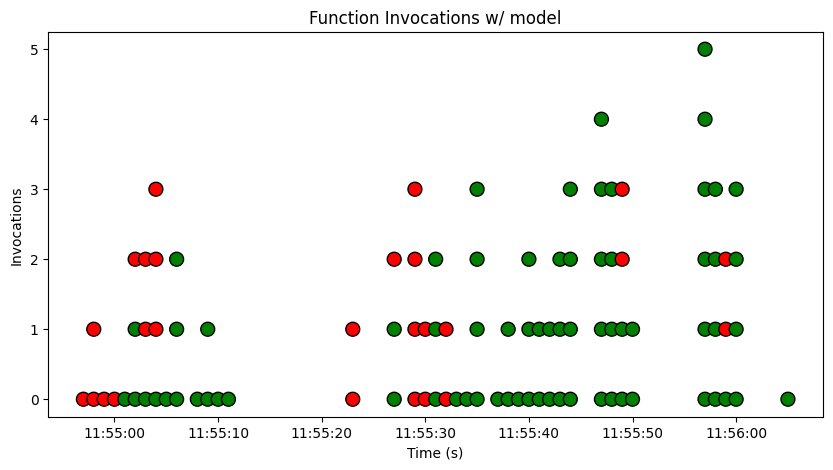

In [6]:
invoked_floor = pd.DataFrame(invoked)
invoked_floor['ds'] = invoked_floor['ds'].dt.floor('s')
invoked_floor['y_jitter'] = invoked_floor.groupby('ds').cumcount()
invoked_floor['color'] = invoked_floor['cold_start'].map({True: 'red', False: 'green'})
plt.figure(figsize=(10, 5))
plt.scatter(invoked_floor['ds'], invoked_floor['y_jitter'], c=invoked_floor['color'], edgecolors='black', s=100)
plt.xlabel("Time (s)")
plt.ylabel("Invocations")
plt.title('Function Invocations w/ model')

Text(0.5, 1.0, 'Function Invocations w/o model')

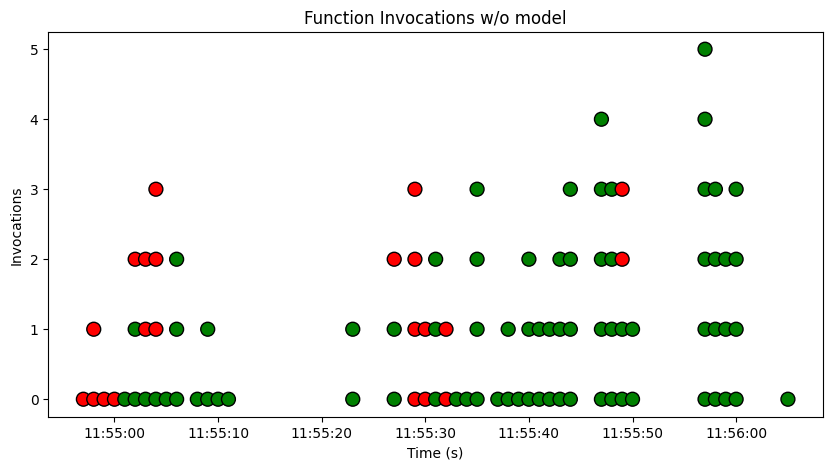

In [7]:
invoked_floor_no = pd.DataFrame(invoked_no)
invoked_floor_no['ds'] = invoked_floor_no['ds'].dt.floor('s')
invoked_floor_no['y_jitter'] = invoked_floor_no.groupby('ds').cumcount()
invoked_floor_no['color'] = invoked_floor_no['cold_start'].map({True: 'red', False: 'green'})
plt.figure(figsize=(10, 5))
plt.scatter(invoked_floor_no['ds'], invoked_floor_no['y_jitter'], c=invoked_floor_no['color'], edgecolors='black', s=100)
plt.xlabel("Time (s)")
plt.ylabel("Invocations")
plt.title('Function Invocations w/o model')